# Lab Solution - Generating Names with a Character-Level RNN
This notebook serves as the starter code and lab description for the Lab covering **Chapter 21 - Deep Learning (Part 2)** from the book *Artificial Intelligence: A Modern Approach.*

In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import random
import string # used for defining `all_letters` variable
import time
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## OVERVIEW
In the lecture, we have reviewed the general architecture of RNNs and we discussed their application in time varying states. In this lab, we get our hands dirty, create an RNN module and use it to generate names for a certain language.

### Data
For this task, I have already downloaded the name data from [here](https://download.pytorch.org/tutorial/data.zip) and cleaned it up (removed accents and turned unicode to ascii) and saved it in a json file. Lets load up the data set and see a couple of names from it.

In [2]:
names = json.loads(open("names_dataset.json", "r").read())
all_languages = list(names.keys())
print("Here are all the languages for which we have some names in our dataset:\n\t\t{}\n".format(all_languages))
print("And here are some names in lets say 'Czech' language:\n\t\t{}".format("|".join(names['Czech'][:10])))

Here are all the languages for which we have some names in our dataset:
		['Czech', 'Scottish', 'Greek', 'Japanese', 'German', 'Korean', 'Chinese', 'Dutch', 'Portuguese', 'Arabic', 'English', 'Spanish', 'Irish', 'Vietnamese', 'French', 'Polish', 'Russian', 'Italian']

And here are some names in lets say 'Czech' language:
		Abl|Adsit|Ajdrna|Alt|Antonowitsch|Antonowitz|Bacon|Ballalatak|Ballaltick|Bartonova


We also consider the following set of all possible letters that could appear in a name which will later come in handy.

In [4]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

Let's create helper functions to get random pairs of (language, name):

In [5]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random language and random name from that language
def randomTrainingPair():
    r_lang = randomChoice(all_languages)
    r_name = randomChoice(names[r_lang])
    return r_lang, r_name

# This helper function will take a `time.time()` and returns the time difference since that time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Creating the model
Now, lets turn our focus to the model design. For each timestep (that is, for each letter in a training word - e.g. name) the inputs of the network will be ``(language, current letter in name, hidden state)`` and the outputs will be ``(next letter in name, next hidden state)``. 

So for each training set, we'll need the language, a set of current letters, and a set of output/next
letters coverted to tensors.

Fill out the next three functions which are simply receiving either a `language` or a `name` in a language and convert it to a proper format of tensor. In the process, please keep in mind that for the RNNs normally the input tensors are in [`one-hot`](https://en.wikipedia.org/wiki/One-hot) format while the output tensors are **not**.

### `currentLetterTensor(name)`
The first input creation method is `currentLetterTensor` which receives a string formatted `name` creates a `zeros` **float** tensor of size (`name_length` $\times$ `1` $\times$ `n_letters`). Lets call this newly created tensor `result`. Then for each letter in `name` (in position `letter_position` of the `name`), it looks up to `find` the letter index (let's call it `letter_vocab_id`) in the set of `all_letters` (vocabulary of all letters that could happen in a name). Next, it will set `result[letter_position][0][letter_vocab_id]` to `1`.

**Important note: don't forget to call `.to(device)` on any tensor that you create to make sure it is properly located in CPU/GPU.**

In [6]:
# TODO create `currentLetterTensor` function
def currentLetterTensor(name):
    result = torch.zeros(len(name), 1, n_letters).float()
    for letter_position in range(len(name)):
        result[letter_position][0][all_letters.find(name[letter_position])] = 1
    return result.to(device)

### `languageTensor()`
Next input creation method will be `languageTensor` (implemented pretty much like the previous one) which receives a string formatted `language` and creates a `zeros` **float** tensor of size (`1` $\times$ `len_all_languages`). Lets call this newly created tensor `result`. Then it looks up the `index` of the passed in `language` in `all_languages` and sets `result[0][looked_up_index]` to `1`. 

*When training we feed this tensor to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.*


**Important note: don't forget to call `.to(device)` on any tensor that you create to make sure it is properly located in CPU/GPU.**

In [7]:
# TODO create `languageTensor` function
def languageTensor(language):
    result = torch.zeros(1, len(all_languages)).float()
    result[0][all_languages.index(language)] = 1
    return result.to(device)

### `nextLetterTensor()`
The last method is the one that creates the output tensor which will help the loss creation module determine whether the prediction has been correct or not. Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

<img width="600" src="https://i.imgur.com/JH58tXY.png">

Like `currentLetterTensor`, this method also receives a string formatted `name`. However, as we said, its not an input tensor so we don't need to convert the `name` into one-hot format. Instead, using the same technique that we did for `currentLetterTensor` we convert all the letters of `name` into their `letter_vocab_id` **ignoring the first letter** (since its not going to be predicted; its assumed as always to be given in our problem). We then put these converted `letter_vocab_id`s into a list (preserving the order). As the last step we append the id of **end-of-sequence** (*EOS*) token (which we have assumed to be `n_letters - 1`) to the end of the resulting list. Convert the created list of ids to a tensor by simply passing it to `torch.LongTensor`.

**Important note: don't forget to call `.to(device)` on any tensor that you create to make sure it is properly located in CPU/GPU.**

In [8]:
# TODO create `nextLetterTensor` function
def nextLetterTensor(name):
    result = [all_letters.find(name[letter_position]) for letter_position in range(1, len(name))]
    result.append(n_letters - 1) # EOS
    return torch.LongTensor(result).to(device)

### Putting it all together
For convenience during training we'll make a ``getRandomTrainingExample`` function that fetches a random `(language, name)` pair and turns them into the required (`language`, `currentLetter`, `nextLetter`) tensors.

In [9]:
def getRandomTrainingExample():
    r_lang, r_name = randomTrainingPair()
    language_tensor = languageTensor(r_lang)
    current_letter_tensor = currentLetterTensor(r_name)
    next_letter_tensor = nextLetterTensor(r_name)
    return language_tensor, current_letter_tensor, next_letter_tensor

## Model  Design
Now that the training data is worked out, we need to design a proper neural network architecture based on our learning objective. This process is the same in pretty much every single new task. If you remember, earlier we mentioned that the letters are appearing one after another in the names and we want to train a network that can learn the probability of each letter given the previous letter (that have already been generated). As you know, the dependence of each letter to the letters that have appeared before itself can be modelled using a recurrent neural network.

Now, we can either go ahead and use the off-the-shelf designed RNNs (e.g. [`torch.nn.GRU`](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)), or in our case, we can design a new recurrent neural network architecture. We mainly do this to learn how to make a new neural network architecture ([`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)), but it also is good because our task doesn't need lots of complexities with which the off-the-shelf designed RNNs are packaged.

In this section, you will implement your first torch `Module`, but since you are new to the task, the design has already been provided to you and you will simply look at the network graph and try to implement it. Here is the designed network architecture:

<img width="720" src="Model.svg">

To implement this architecture follow this step-by-step guidelines:
1. Create a class and name it `RNN`.
2. Make the class inherit from `torch.nn.Module`. This way your class is automatically considered as a torch module and can be saved, loaded, and passed to loss calculators for auto-grad calculation.
    - In addition to `__init__` function, add two other functions to your class; `forward` and `initHidden`. The following points will explain how you will implement each function.
3. The `__init__` function is where you initialize all the components of the module. 
    - The inputs to this function would be the input, hidden layer and output sizes
    - First function call would be to the `__init__` function of the supercalss (`torch.nn.Module`)
    - Next, create the three `nn.Linear` modules as depicted in the graph design. The connections of these modules will be implemented in the `forward` function.
    - The output size of `m1` will be of `output_size`.
    - The output size of `m2` will be of `hidden_size`.
    - The output size of `m3` will be of `output_size`.
    - Also, create an instance of [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) with `dim=-1`.
4. The `initHidden` function will always return a `zeros` vector of size (`1` $\times$ `hidden_size`). **Make sure you call `.to(device)` on the created tensor**.
5. The `forward` function is the most important function which is inherited from `torch.nn.Module`. This function is automatically called when an input is passed to the module instance and it atomatically updates the gradient values in the computation graph unless `with torch.no_grad():` is in effect. In this function, you describe how your input ``(language, current letter in name, hidden state)`` is converted to the expected output  ``(next letter in name, next hidden state)``, and the only tools you have at your disposal are the modules instantiated in `__init__` function.
    - Take `language`, `current_letter`, and `hidden_vector` as input to this function. The initial value of `hidden_vector` will be provided from `initHidden` function.
    - As stated in the diagram, using [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html), concatenate all the input tensors and pass them to the linear modules `m1` and `m2` producing the outputs `mo1` and `mo2`. Concatenate `mo1` and `mo2` and pass it through the third linear module `m3` and pass its result through the log_softmax instance to get `res`. Return `mo1` as the next hidden state and return `res` as the produced output.

In [10]:
# TODO implement the RNN module using the step-by-step guide mentioned above.
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        n_categories = len(all_languages)
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, language, input, hidden):
        input_combined = torch.cat((language, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

As we said in the previous lab, we also need a loss calculator. For training RNNs, the default training loss objective is Negative Log Likelihood loss.

In [11]:
criterion = nn.NLLLoss()

## Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step. The magic of autograd allows you to simply sum these losses at each step and call backward at the end. The code provided in the next cell preforms all of what needs to be done to create and train our designed RNN module. If you have properly implemented the RNN module and data provider functions, this code should runn smoothly. Give it a bit of time to train (I'm expecting less than 10 minutes on a GPU and between 10 to 15 minutes on a CPU). Once its done in your own language explain what it does and what is happening during training iterations.


### TODO: explain what is happening in the next cell
...


In [12]:
learning_rate = 0.0005
hidden_layer_size = 128
n_iters = 100000
print_every = 5000
plot_every = 500

rnn = RNN(n_letters, hidden_layer_size, n_letters)

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

i_tqdm = tqdm(range(1, n_iters + 1))
for iter in i_tqdm:
    language_tensor, current_letter_tensor, next_letter_tensor = getRandomTrainingExample()
    next_letter_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(current_letter_tensor.size(0)):
        output, hidden = rnn(language_tensor, current_letter_tensor[i], hidden)
        l = criterion(output, next_letter_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    output, loss = output, loss.item() / current_letter_tensor.size(0)
    total_loss += loss

    i_tqdm.set_description('Loss: %.4f' % (loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

7m 41s (100000 100%) 1.2898: 100%|██████████| 100000/100000 [07:41<00:00, 216.66it/s]


Once we are done, we can also take a look at the training loss vs. training instance numbers:

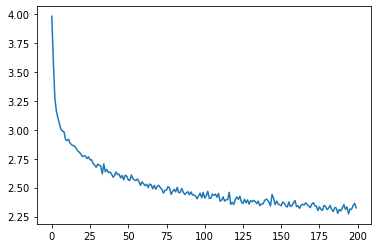

In [13]:
plt.figure()
plt.plot(all_losses)

## Sampling the Network

The last step is to perform new name generation using our trained model. To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the *EOS token* is generated.

Fill out the `sample` function using the step-by-step guidelines provided here (you can use the code in the train cell as some help to implement this function):

1.  Have the function receive the language, the letter with which the name is supposed to start and the maximum expected length of the name.
2.  Create tensors for input language, starting letter, and empty hidden state.
3.  Create a string ``output_name`` with the starting letter.
4.  Up to the maximum expected output length:

   -  Feed the `(language, current letter, hidden state)` to the network.
   -  Get the next letter from highest probability output, and next hidden state.
       - To find the highest probability item in output tensor, you need to call [`.topk(1)`](https://pytorch.org/docs/stable/generated/torch.topk.html) on your tensor.
   -  If the letter is EOS, stop here.
   -  If a regular letter, add to ``output_name`` and continue.

5.  Return the final name.

**Note(1): since the sample method is not supposed to change the RNN network, make sure you put all the code within a `with torch.no_grad():` block.**

**Note(2): rather than having to give it a starting letter, another strategy would have been to include a "start of string" token in training and have the network choose its own starting letter.**

In [14]:
# TODO create `sample` function here
def sample(language, start_letter='A', max_length = 20):
    with torch.no_grad():  # no need to track history in sampling
        language_tensor = languageTensor(language)
        input = currentLetterTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(language_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = currentLetterTensor(letter)

        return output_name

Now, that we are done implementing the `sample` function, lets generate a few names in different languages:

In [15]:
# Get multiple samples from one language and multiple starting letters
def samples(language, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(language, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rongov
Uanton
Santan
Gangerr
Eren
Ronger
Sella
Pandel
Aller
Cha
Han
Iui
